In [4]:
import random 
import os 
import pandas as pd 

import os
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, models
from PIL import Image

import matplotlib.pyplot as plt






In [5]:
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA available: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [6]:
import torch
print("Torch version:", torch.__version__)
print("Built with CUDA?:", torch.version.cuda)
print("CUDA available?:", torch.cuda.is_available())

Torch version: 2.5.1+cu121
Built with CUDA?: 12.1
CUDA available?: True


In [7]:
import os
import shutil
import pandas as pd

# Paths
image_dir = r"C:/Users/Kelly/Downloads/img_align_celeba/img_align_celeba"  # folder containing all images
partition_path = r"C:/Users/Kelly/Downloads/list_eval_partition.txt"
output_dir = r"C:/Users/Kelly/Downloads/img_align_celeba_subset"

# Make sure output folder exists
os.makedirs(output_dir, exist_ok=True)

# Read partition info
partition_df = pd.read_csv(partition_path, sep=r"\s+", header=None, names=["image_id", "partition"])

# Sample images from each split
train_df = partition_df[partition_df['partition'] == 0].sample(n=20000, random_state=42)
val_df = partition_df[partition_df['partition'] == 1].sample(n=5000, random_state=42)
test_df = partition_df[partition_df['partition'] == 2].sample(n=5000, random_state=42)

# Combine all
subset_df = pd.concat([train_df, val_df, test_df])

# Copy files to new folder
for filename in subset_df["image_id"]:
    src = os.path.join(image_dir, filename)
    dst = os.path.join(output_dir, filename)
    if os.path.exists(src):
        shutil.copyfile(src, dst)

print("Subset created at:", output_dir)
print("Total files copied:", len(os.listdir(output_dir)))




KeyboardInterrupt: 

In [7]:
print("Split summary:")
print(f"Train set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

Split summary:
Train set: 20000 images
Validation set: 5000 images
Test set: 5000 images


In [8]:
partition_df.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


Start running here 

In [1]:
import os
import pandas as pd

# Paths
attr_path = "C:/Users/Kelly/Downloads/list_attr_celeba.txt"
partition_path = "C:/Users/Kelly/Downloads/list_eval_partition.txt"
subset_dir = "C:/Users/Kelly/Downloads/img_align_celeba_subset"


# 1. Get all image filenames in the subset folder
subset_filenames = os.listdir(subset_dir)
subset_filenames = [f for f in subset_filenames if f.endswith('.jpg')]  # only .jpg files

# 2. Load partition info
df_partition = pd.read_csv(partition_path, sep=r'\s+', header=None, names=['image_id', 'partition'])

# 3. Load attributes (skip the first line, use image_id as index)
df_attr = pd.read_csv(attr_path, sep=r'\s+', skiprows=1)
df_attr.index.name = 'image_id'

# 4. Join partition info with Male attribute
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how='inner')

# 5. Filter to only images in the subset folder
df_par_attr_subset = df_par_attr[df_par_attr.index.isin(subset_filenames)]

# 5½. Push index into a column called "image_id"
df_par_attr_subset = df_par_attr_subset.reset_index().rename(columns={'image_id':'image_id'})

# 6. Convert -1/1 to 0/1 for binary classification
df_par_attr_subset['Male'] = df_par_attr_subset['Male'].apply(lambda x: 1 if x == 1 else 0)

# 7. Split based on partition column
train_df = df_par_attr_subset[df_par_attr_subset['partition'] == 0]
val_df   = df_par_attr_subset[df_par_attr_subset['partition'] == 1]
test_df  = df_par_attr_subset[df_par_attr_subset['partition'] == 2]

# ✅ Print counts
print("✅ Subset shape:", df_par_attr_subset.shape)
print("Train set:", train_df.shape)
print("Validation set:", val_df.shape)
print("Test set:", test_df.shape)

# Optional: preview
train_df.head()
val_df.head()
test_df.head()

✅ Subset shape: (30000, 3)
Train set: (20000, 3)
Validation set: (5000, 3)
Test set: (5000, 3)


,image_id,partition,Male
25000,182638.jpg,2,0
25001,182641.jpg,2,0
25002,182644.jpg,2,1
25003,182655.jpg,2,0
25004,182657.jpg,2,0


Data Preprocessing

In [3]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# 1️⃣ Transforms
train_transform = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop((227,227), scale=(0.8,1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_test_transform = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# 2️⃣ Dataset
class CelebADataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image_id"])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(int(row["Male"]), dtype=torch.float32)
        return img, label

# 3️⃣ Instantiate DataLoaders
image_dir = "C:/Users/Kelly/Downloads/img_align_celeba_subset"
train_ds = CelebADataset(train_df, image_dir, transform=train_transform)
val_ds   = CelebADataset(val_df,   image_dir, transform=val_test_transform)
test_ds  = CelebADataset(test_df,  image_dir, transform=val_test_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

# 4️⃣ Sanity check
images, labels = next(iter(train_loader))
print("Train batch shapes → images:", images.shape, ", labels:", labels.shape)



Train batch shapes → images: torch.Size([32, 3, 227, 227]) , labels: torch.Size([32])


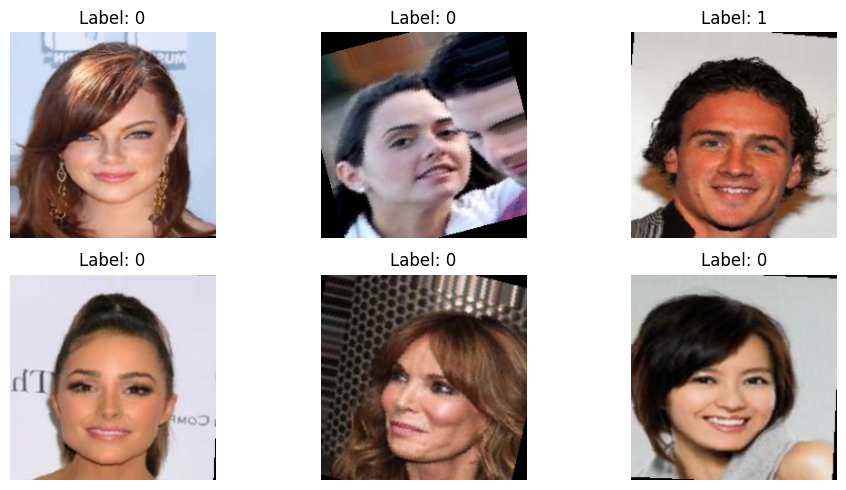

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Utility to reverse normalization
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

# Grab one batch
images, labels = next(iter(train_loader))

# Move to CPU and convert to NumPy
images = images.cpu().numpy()
labels = labels.cpu().numpy()

plt.figure(figsize=(10, 5))
for i in range(6):
    img = images[i].transpose(1, 2, 0)  # C×H×W → H×W×C
    img = std * img + mean             # Denormalize
    img = np.clip(img, 0, 1)

    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"Label: {int(labels[i])}")
    plt.axis('off')

plt.tight_layout()
plt.show()



Models 

InceptionV3

In [6]:
!pip install torch-summary

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import inception_v3, Inception_V3_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ───── Wrapper to resize inputs and handle aux_logits ─────
class ResizeInception(nn.Module):
    def __init__(self, base):
        super().__init__()
        self.resize = nn.Upsample(size=(299,299), mode='bilinear', align_corners=False)
        self.base = base

    def forward(self, x):
        x = self.resize(x)
        # Ignore the auxiliary output
        if self.training:
            outputs, _ = self.base(x)
            return outputs
        else:
            return self.base(x)

# ───── Load pretrained InceptionV3 ─────
# We have to use aux_logits=True with pretrained weights
base = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)

# ───── Replace classifier head ─────
in_features = base.fc.in_features
base.fc = nn.Sequential(
    nn.Linear(in_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

# ───── Wrap with resize module ─────
model = ResizeInception(base).to(device)

# ───── Freeze first 52 parameters ─────
params = list(model.parameters())
for p in params[:52]:
    p.requires_grad = False

print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

# ───── Optimizer + Loss ─────
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.BCELoss()

# Use evaluation mode for the test to avoid aux_logits issues
model.eval()

# Create a sample input with batch size of 2
sample_input = torch.randn(2, 3, 227, 227).to(device)
print(f"Input shape: {sample_input.shape}")

# Get output shape
with torch.no_grad():
    output = model(sample_input)
    print(f"Output shape: {output.shape}")

print(model)

Trainable params: 27046409
Input shape: torch.Size([2, 3, 227, 227])
Output shape: torch.Size([2, 1])
ResizeInception(
  (resize): Upsample(size=(299, 299), mode='bilinear')
  (base): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import inception_v3, Inception_V3_Weights
import matplotlib.pyplot as plt
import random
import numpy as np

# ───── DEVICE SETUP ─────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ───── Wrapper to resize inputs and handle aux_logits ─────
class ResizeInception(nn.Module):
    def __init__(self, base):
        super().__init__()
        self.resize = nn.Upsample(size=(299,299), mode='bilinear', align_corners=False)
        self.base = base

    def forward(self, x):
        x = self.resize(x)
        # Correctly handle auxiliary outputs during training
        if self.training and self.base.aux_logits:
            outputs, _ = self.base(x)  # Discard the auxiliary output
            return outputs
        else:
            return self.base(x)

# ───── Load pretrained InceptionV3 ─────
base = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)

# ───── Replace classifier head ─────
in_features = base.fc.in_features
base.fc = nn.Sequential(
    nn.Linear(in_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

# ───── Wrap with resize module ─────
model = ResizeInception(base).to(device)

# ───── Freeze first 52 parameters ─────
params = list(model.parameters())
for p in params[:52]:
    p.requires_grad = False

print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

# ───── Optimizer + Loss ─────
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.BCELoss()

# ─── SET REPRODUCIBILITY ───────────────────────────────────────────────────────────
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ─── TRAINING + EARLY STOPPING ─────────────────────────────────────────────────────
history = {
    "train_loss": [], "train_acc": [],
    "val_loss": [],   "val_acc": [],
    "test_loss": [],  "test_acc": []
}

best_val_acc = 0.0
patience = 5
epochs_no_improve = 0
best_path = "C:/Users/Kelly/Downloads/SC4001/weights/inception_gender.pth"

for epoch in range(1, 51):
    # ---------- TRAIN ----------
    model.train()
    running_loss = correct = total = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = (outputs>0.5).float()
        correct += (preds==labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss/total
    train_acc  = correct/total

    # ---------- VALIDATION ----------
    model.eval()
    running_loss = correct = total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            preds = (outputs>0.5).float()
            correct += (preds==labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss/total
    val_acc  = correct/total

    # ---------- TEST ----------
    running_loss = correct = total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            preds = (outputs>0.5).float()
            correct += (preds==labels).sum().item()
            total += labels.size(0)

    test_loss = running_loss/total
    test_acc  = correct/total

    # Store history
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)

    print(f"Epoch {epoch} ▶ train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f} | "
          f"test_loss={test_loss:.4f}, test_acc={test_acc:.4f}")

    # Checkpoint & EarlyStopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)
        epochs_no_improve = 0
        print("✅ Saved best model")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"🛑 Early stopping at epoch {epoch}")
            break

print(f"Best validation accuracy: {best_val_acc:.4f}")

# Plotting code for visualization
def plot_history():
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(14, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["test_loss"],  label="Test Loss")
    plt.title("Loss vs Epoch")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["test_acc"],  label="Test Accuracy")
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
    
    plt.tight_layout()
    plt.show()

# After training, call this to visualize results
# plot_history()

Using device: cuda
Trainable params: 27046409
Epoch 1 ▶ train_loss=0.1373, train_acc=0.9405 | val_loss=0.0536, val_acc=0.9802 | test_loss=0.0699, test_acc=0.9740
✅ Saved best model
Epoch 2 ▶ train_loss=0.0608, train_acc=0.9788 | val_loss=0.0606, val_acc=0.9784 | test_loss=0.0687, test_acc=0.9750
Epoch 3 ▶ train_loss=0.0470, train_acc=0.9842 | val_loss=0.0454, val_acc=0.9832 | test_loss=0.0578, test_acc=0.9790
✅ Saved best model
Epoch 4 ▶ train_loss=0.0412, train_acc=0.9869 | val_loss=0.0699, val_acc=0.9742 | test_loss=0.0824, test_acc=0.9720
Epoch 5 ▶ train_loss=0.0321, train_acc=0.9889 | val_loss=0.0597, val_acc=0.9820 | test_loss=0.0599, test_acc=0.9824
Epoch 6 ▶ train_loss=0.0280, train_acc=0.9899 | val_loss=0.0508, val_acc=0.9824 | test_loss=0.0738, test_acc=0.9782
Epoch 7 ▶ train_loss=0.0243, train_acc=0.9915 | val_loss=0.0525, val_acc=0.9840 | test_loss=0.0682, test_acc=0.9804
✅ Saved best model
Epoch 8 ▶ train_loss=0.0213, train_acc=0.9926 | val_loss=0.0623, val_acc=0.9826 | tes

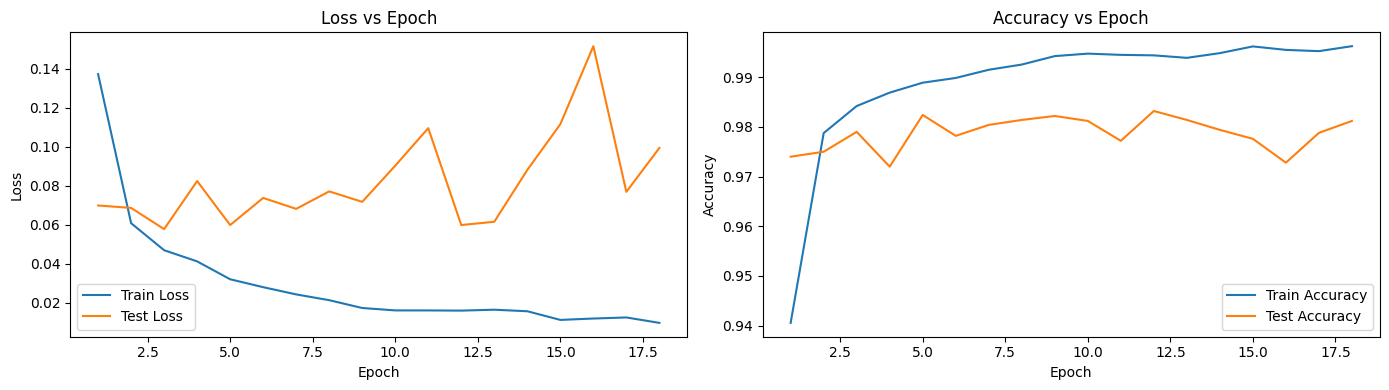

In [15]:
plot_history()

EfficientNetV2- S

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ───── Wrapper to resize inputs ─────
class ResizeEfficientNetV2(nn.Module):
    def __init__(self, base):
        super().__init__()
        # EfficientNetV2-S typically expects 384x384 inputs
        self.resize = nn.Upsample(size=(384, 384), mode='bilinear', align_corners=False)
        self.base = base

    def forward(self, x):
        x = self.resize(x)
        return self.base(x)

# ───── Load pretrained EfficientNetV2-S ─────
weights = EfficientNet_V2_S_Weights.DEFAULT
base = efficientnet_v2_s(weights=weights)

# ───── Replace classifier head ─────
# The classifier is a Sequential module; the second element is the Linear layer.
in_features = base.classifier[1].in_features
base.classifier = nn.Sequential(
    nn.Linear(in_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

# ───── Wrap the model with the resize module ─────
model = ResizeEfficientNetV2(base).to(device)

# ───── Freeze the first 52 parameters ─────
params = list(model.parameters())
for p in params[:52]:
    p.requires_grad = False

print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

# ───── Set up optimizer and loss ─────
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.BCELoss()

# Use evaluation mode for testing
model.eval()

# Create a sample input with a batch size of 2
sample_input = torch.randn(2, 3, 227, 227).to(device)
print(f"Input shape: {sample_input.shape}")

# Get output shape
with torch.no_grad():
    output = model(sample_input)
    print(f"Output shape: {output.shape}")

print(model)


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to C:\Users\Kelly/.cache\torch\hub\checkpoints\efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:03<00:00, 26.1MB/s]


Trainable params: 21127673
Input shape: torch.Size([2, 3, 227, 227])
Output shape: torch.Size([2, 1])
ResizeEfficientNetV2(
  (resize): Upsample(size=(384, 384), mode='bilinear')
  (base): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
    